# Final assignment 

This notebook develops the practice part of the final assignment. The writing part can be found [here](https://github.com/lucasmoschen/phd-bayesian-statistics/blob/main/notes/final_assignment/A2.pdf).

## Inferring population sizes - practice

Consider the problem of inferring the population sizes of major herbivores. In the first case, one is interested in estimating the number of impala (*Aepyceros melampus*) herds in the Kruger National Park, in northeastern South Africa. In an initial survey collected the following numbers of herds: $\boldsymbol{x}_{\text{impala}} = \{15, 20, 21, 23, 26\}$. Another scientific question is the number of individual waterbuck (*Kobus ellipsiprymnus*) in the same park. The observed numbers of waterbuck in separate sightings were $\boldsymbol{x}_{\text{waterbuck}} = \{53, 57, 66, 67, 72\}$ and may be regarded (for simplicity) as independent and identically distributed.

Impala           |  Waterbuck
:-------------------------:|:-------------------------:
![impala](../notes/final_assignment/figures/impala.jpeg)|![waterbuck](../notes/final_assignment/figures/waterbuck.jpeg)
Two antelope species whose population sizes we want to estimate.

For each data set, sketch the marginal posterior distributions $p_1(N \mid \boldsymbol{x})$, $p_2(N \mid \boldsymbol{x})$ and $p_3(N \mid \boldsymbol{x})$. Moreover, under each posterior,  provide (i) the Bayes estimator under quadratic loss and under the relative quadratic loss and (ii) a 95\% credibility interval for $N$.

Discuss the differences and similarities between these distributions and estimates: do the prior modelling choices substantially impact the final inferences? If so, how?

In [1]:
import numpy as np 
import pystan as ps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
pd.set_option("display.precision", 2)


import pymc3 as pm
import arviz as az

from scipy.special import beta, comb

### Raftery approach

We define the model for the Raftery approach. 

In [2]:
model_raftery = """
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> a;
    real<lower = 0> b;
    real<lower = 0> alpha;
    real<lower = 0> beta;
}
transformed data{
    real S = sum(x_obs);
}
parameters{ 
    real<lower = 0, upper = 1> theta;
    real<lower = max(x_obs)> N; 
}
transformed parameters{
    real lPbar = 0.0;
    for(j in 1:n) lPbar += lchoose(N, x_obs[j]);
}
model{
    target += lPbar + lgamma(alpha + N) - lgamma(N+1);
    target += (a+S-1-N)*log(theta) + (b+n*N -S - 1)*log(1-theta); 
    target += -(alpha+N)*log(beta + 1/theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [ ]:
sm_raft = ps.StanModel(model_code = model_raftery)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_696db612137e19e852243acc471e9eb6 NOW.


### Raftery + uniformative

The model is the same as previous, but with $\alpha = \beta = 0$ and $a = b = 1$. 

### Geometric independent approach

We define the model for the Geometric and independent approach. 

In [ ]:
model_geom = """
functions {
  real geometric_real_lpdf(real N, real p){
      return N*log(1 - p) + log(p);
  }
  real binomial_real_lpmf(int[] x, real n, real p){
      real lpbar = 0.0;
      for(j in 1:size(x)) lpbar += lchoose(n, x[j]);
      return lpbar + sum(x)*log(p) + (size(x)*n - sum(x))*log(1 - p);
  }
}
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> alpha1;
    real<lower = 0> beta1;
    real<lower = 0> alpha2;
    real<lower = 0> beta2;
}
parameters{ 
    real<lower = max(x_obs)> N;
    real<lower = 0, upper = 1> theta;
    real<lower = 0, upper = 1> nu;
}
model{
    theta ~ beta(alpha2, beta2);
    nu ~ beta(alpha1, beta1);
    
    N ~ geometric_real(nu);
    
    x_obs ~ binomial_real(N, theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [ ]:
sm_geom_id = ps.StanModel(model_code=model_geom)

### Geometric correlated approach 

We define the model for the Geometric and correlatedreallen approach. 

In [ ]:
model_geom_corr = """
functions {
  real geometric_real_lpdf(real N, real p){
      return N*log(1 - p) + log(p);
  }
  real binomial_real_lpmf(int[] x, real n, real p){
      real lpbar = 0.0;
      for(j in 1:size(x)) lpbar += lchoose(n, x[j]);
      return lpbar + sum(x)*log(p) + (size(x)*n - sum(x))*log(1 - p);
  }
}
data{
    int<lower = 0> n;
    int x_obs[n];
    
    vector[2] eta; 
    cov_matrix[2] Sigma;
}
parameters{ 
    real<lower = max(x_obs)> N;
    vector[2] probs_logit;  
}
transformed parameters{
    real theta = inv_logit(probs_logit[2]);
    real nu = inv_logit(probs_logit[1]);
}
model{
    probs_logit ~ multi_normal(eta, Sigma);
    
    N ~ geometric_real(nu);
    
    x_obs ~ binomial_real(N, theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [ ]:
sm_geom_corr = ps.StanModel(model_code=model_geom_corr)

## Experimenting after defining the models 

Now we use the data to test the models 

### Data

In [ ]:
impala = np.array([15,20,21,23,26])
waterbuck = np.array([53,57,66,67,72])

### Impala data

First we use the impala data to deal with the problems. 

In [ ]:
raft_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 1.,
    'beta': 1.,
}

fit_raftery = sm_raft.sampling(data=raft_data, iter=50000, chains=5,
                               control=dict(adapt_delta=0.95))

print(fit_raftery)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_raftery.extract()["N"], bins = range(26, 200), density = True)
plt.show()

### Prior predictive checking

In [ ]:
theta = np.random.beta(raft_data["a"], raft_data["b"], 100000)
lambd = np.random.gamma(raft_data["alpha"], raft_data["beta"], 100000)
mu = lambd/theta
N = np.random.poisson(mu)

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].hist(mu, bins = np.arange(0,20,0.5), density = True, histtype = 'step')
ax[1].hist(N, bins = range(26, 400, 5), density = True, histtype = 'step')

ax[1].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\mu$")
plt.show()

In [ ]:
uninf_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

print(fit_uninf)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_uninf.extract()["N"], bins = range(26, 500), density = True)
plt.show()

In [ ]:
geom_id_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'alpha1': 1, 
    'alpha2': 1,
    'beta1': 1,
    'beta2': 1,
}

fit_geom_id = sm_geom_id.sampling(data=geom_id_data, iter=50000, chains=5,
                                control=dict(adapt_delta=0.99))

print(fit_geom_id)

### Prior predictive checking

In [ ]:
nu = np.random.beta(geom_id_data["alpha1"], geom_id_data["beta1"], 100000)
N = np.random.geometric(nu)

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].hist(nu, bins = 100, density = True, histtype = 'step')
ax[1].hist(N, bins = range(26, 400, 5), density = True, histtype = 'step')

ax[1].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\nu$")
plt.show()

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_geom_id.extract()["N"], bins = range(26, 300), density = True)
plt.show()

In [ ]:
geom_corr_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'eta': np.array([0,0]), 
    'Sigma': np.array([[2.5,-1],[-1,2.5]]),
}

fit_geom_corr = sm_geom_corr.sampling(data=geom_corr_data, iter=50000, chains=5,
                                 control=dict(adapt_delta=0.96))

print(fit_geom_corr)

### Prior predictive checking

In [ ]:
logit_par = np.random.multivariate_normal(geom_corr_data['eta'], geom_corr_data['Sigma'], 10000)

theta = 1/(1 + np.exp(logit_par[:,0]))
nu = 1/(1 + np.exp(logit_par[:,1]))
N = np.random.geometric(nu)

fig, ax = plt.subplots(1,3,figsize = (15,4))
ax[0].hist(theta, bins = 100, density = True, histtype = 'step')
ax[1].hist(nu, bins = 100, density = True, histtype = 'step')
ax[2].hist(N, bins = range(0,20), density = True, histtype = 'step')

ax[2].set_title("Prior distribution N")
ax[0].set_title(r"Prior distribution $\theta$")
ax[1].set_title(r"Prior distribution $\nu$")
plt.show()

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_geom_corr.extract()["N"], bins = range(26, 200), density = True)
plt.show()

Figure joining the posteriors of $N$

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (20,4))

sns.histplot(fit_raftery.extract()["N"], bins = range(26, 300), ax = ax[0], stat = 'density')
sns.histplot(fit_uninf.extract()["N"], bins = range(26, 300),ax = ax[1], stat = 'density')
sns.histplot(fit_geom_id.extract()["N"], bins = range(26, 300), ax = ax[2], stat = 'density')
sns.histplot(fit_geom_corr.extract()["N"], bins = range(26, 300), ax = ax[3], stat = 'density')

for i in range(4):
    ax[i].set_title(r"$p_{}(N|x)$".format(i+1), fontsize = 14)
    ax[i].set_ylabel(" ")

plt.savefig("../images/marginal-distributions.png", bbox_inches = 'tight')    
plt.show()

### Summary statistics

In [ ]:
raft_N = fit_raftery.extract()["N"]
uninf_N = fit_uninf.extract()["N"]
geom_id_N = fit_geom_id.extract()["N"]
geom_corr_N = fit_geom_corr.extract()["N"]

se = {
    'Mean': [raft_N.mean(), uninf_N.mean(), geom_id_N.mean(), geom_corr_N.mean()],
    'Median': [np.median(raft_N), np.median(uninf_N), np.median(geom_id_N), np.median(geom_corr_N)],
    'MRSE': [(1/raft_N).mean()/(1/raft_N**2).mean(), (1/uninf_N).mean()/(1/uninf_N**2).mean(),
             (1/geom_id_N).mean()/(1/geom_id_N**2).mean(), (1/geom_corr_N).mean()/(1/geom_corr_N**2).mean()],
    'HDI': [az.hdi(raft_N, hdi_prop = 0.95), az.hdi(uninf_N, hdi_prop = 0.95), 
            az.hdi(geom_id_N, hdi_prop = 0.95), az.hdi(geom_corr_N, hdi_prop = 0.95)]
}

summary_statistics = pd.DataFrame(se)
summary_statistics

### Waterbuck data

In [ ]:
raft_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 1.,
    'beta': 1.,
}

fit_raftery = sm_raft.sampling(data=raft_data, iter=50000, chains=5,
                               control=dict(adapt_delta=0.95))

print(fit_raftery)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_raftery.extract()["N"], bins = range(73, 200), density = True, edgecolor = "none")
plt.show()

In [ ]:
uninf_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

print(fit_uninf)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_uninf.extract()["N"], bins = range(76, 1000,5), density = True, edgecolor = "none")
plt.show()

In [ ]:
geom_id_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'alpha1': 1, 
    'alpha2': 1,
    'beta1': 1,
    'beta2': 1,
}

fit_geom_id = sm_geom_id.sampling(data=geom_id_data, iter=50000, chains=5,
                                control=dict(adapt_delta=0.99))

print(fit_geom_id)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_geom_id.extract()["N"], bins = range(70, 500), density = True, edgecolor = "none")
plt.show()

In [ ]:
geom_corr_data = {
    "x_obs": waterbuck,
    "n": waterbuck.shape[0],
    'eta': np.array([0,0]), 
    'Sigma': np.array([[2.5,-1],[-1,2.5]]),
}

fit_geom_corr = sm_geom_corr.sampling(data=geom_corr_data, iter=50000, chains=5,
                                 control=dict(adapt_delta=0.96))

print(fit_geom_corr)

### Marginal posterior of $N$

In [ ]:
plt.hist(fit_geom_corr.extract()["N"], bins = range(75, 300), density = True, edgecolor = "none")
plt.show()

Figure joining the posteriors of $N$

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (20,4))

sns.histplot(fit_raftery.extract()["N"], bins = range(70, 500), ax = ax[0], stat = 'density')
sns.histplot(fit_uninf.extract()["N"], bins = range(70, 1000),ax = ax[1], stat = 'density')
sns.histplot(fit_geom_id.extract()["N"], bins = range(70, 500), ax = ax[2], stat = 'density')
sns.histplot(fit_geom_corr.extract()["N"], bins = range(70, 500), ax = ax[3], stat = 'density')

for i in range(4):
    ax[i].set_title(r"$p_{}(N|x)$".format(i+1), fontsize = 14)
    ax[i].set_ylabel(" ")

plt.savefig("../images/marginal-distributions-waterbuck.png", bbox_inches = 'tight')    
plt.show()

### Summary statistics

In [ ]:
raft_N = fit_raftery.extract()["N"]
uninf_N = fit_uninf.extract()["N"]
geom_id_N = fit_geom_id.extract()["N"]
geom_corr_N = fit_geom_corr.extract()["N"]

se = {
    'Mean': [raft_N.mean(), uninf_N.mean(), geom_id_N.mean(), geom_corr_N.mean()],
    'Median': [np.median(raft_N), np.median(uninf_N), np.median(geom_id_N), np.median(geom_corr_N)],
    'MRSE': [(1/raft_N).mean()/(1/raft_N**2).mean(), (1/uninf_N).mean()/(1/uninf_N**2).mean(),
             (1/geom_id_N).mean()/(1/geom_id_N**2).mean(), (1/geom_corr_N).mean()/(1/geom_corr_N**2).mean()],
    'HDI': [az.hdi(raft_N, hdi_prop = 0.95), az.hdi(uninf_N, hdi_prop = 0.95), 
            az.hdi(geom_id_N, hdi_prop = 0.95), az.hdi(geom_corr_N, hdi_prop = 0.95)]
}

summary_statistics = pd.DataFrame(se)
summary_statistics.HDI = summary_statistics.HDI.apply(lambda x: [round(x[0],2), round(x[1],2)])
print(summary_statistics.to_latex())

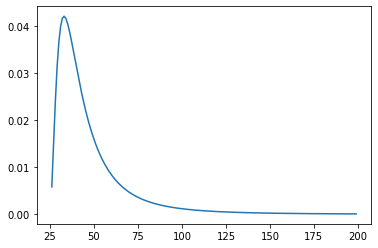

In [202]:
S = sum(impala)
n = len(impala)
xmax = max(impala)

def p1_geom_unnorm(N, x_obs): 
    
    result = np.prod([comb(N,i) for i in x_obs])
    result *= beta(geom_id_data["alpha1"] + 1, N + geom_id_data["beta1"])
    result *= beta(S+geom_id_data["alpha2"], n*N - S + geom_id_data["beta2"])
    return result

constant = 0 
N = 26
eps = 1
while eps > 1e-16: #np.finfo(np.float64).eps: 
    eps = p1_geom_unnorm(N, impala)
    constant += eps
    N += 1
    
def p1_geom(N, x_obs): 
    
    return p1_geom_unnorm(N, x_obs)/constant

N_values = list(range(26,200))
plt.plot(N_values, [p1_geom(N,impala) for N in N_values])

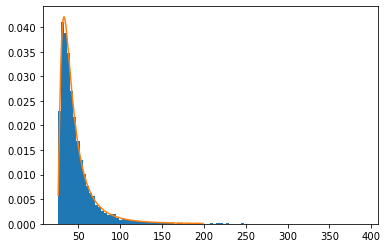

In [209]:
fig, ax = plt.subplots()
ax.hist(fit_geomid.extract()["N"], bins= 100, density = True)
ax.plot(N_values, [p1_geom(N,impala) for N in N_values])